# Соревнование "Simple Housing Price Prediction"  
https://kaggle.com/competitions/simple-housing-price-prediction  
Цель: Спрогнозировать цену продажи домов.  
Метрика качества: MAE (Mean Absolute Error)

Описание признаков:  
`house_id` - переменная ID  
`date` - дата продажи (год и месяц)  
`location` - местоположение дома  
`type` - тип дома  
`block` - блок, в котором находится дом  
`street` - улица, на которой находится дом  
`storey_range` - какие этажи занимает дом  
`flat_model` - модель квартиры, разные буквы представляют разные планировки, архитектуру комнат и т. д.  
`area_sqm` - площадь  
`commence_date` - когда дом был выставлен на продажу  
`price` - целевая переменная, указывает цену, за которую был продан дом  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

RND_STATE = 128
FIGURE_SIZE = (12, 5)

## Импорт данных

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

Сохранение отдельно фрагмента данных для финальной валидации:

In [3]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.1, random_state=RND_STATE)

## Предварительное изучение данных

### Поверхностный взгляд

In [4]:
df_train_train.head()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price
266670,295872,2010-05,Fresno,4 ROOM,155,Pristine Dr,01 TO 03,91.0,K,1984,315000.0
162189,210287,2007-03,Austin,5 ROOM,351,Montoro Dr,25 TO 27,110.0,D,2001,454000.0
87188,266800,2009-06,Milwaukee,4 ROOM,708,W Helena Court,10 TO 12,108.0,G,1995,302000.0
30658,299661,2010-06,Minneapolis,4 ROOM,268C,Flag Ct N,01 TO 03,90.0,L,2006,415000.0
189478,13200,2000-06,Fresno,4 ROOM,24,Red Creek Ct,04 TO 06,92.0,K,1978,215000.0


In [5]:
df_train_train.isna().sum()

house_id         0
date             0
location         0
type             0
block            0
street           0
storey_range     0
area_sqm         0
flat_model       0
commence_date    0
price            0
dtype: int64

In [6]:
df_train_train.dtypes

house_id           int64
date              object
location          object
type              object
block             object
street            object
storey_range      object
area_sqm         float64
flat_model        object
commence_date      int64
price            float64
dtype: object

In [7]:
df_train_train.nunique()

house_id         244548
date                146
location             26
type                  7
block              1982
street              522
storey_range         14
area_sqm            184
flat_model           16
commence_date        45
price              4599
dtype: int64

In [8]:
print(f"type : {df_train_train.type.unique()}\n")
print(f"storey_range : {df_train_train.storey_range.unique()}\n")
print(f"flat_model : {df_train_train.flat_model.unique()}\n")

type : ['4 ROOM' '5 ROOM' 'EXECUTIVE' '3 ROOM' '2 ROOM' '1 ROOM'
 'MULTI-GENERATION']

storey_range : ['01 TO 03' '25 TO 27' '10 TO 12' '04 TO 06' '07 TO 09' '13 TO 15'
 '16 TO 18' '19 TO 21' '22 TO 24' '28 TO 30' '37 TO 39' '40 TO 42'
 '34 TO 36' '31 TO 33']

flat_model : ['K' 'D' 'G' 'L' 'F' 'C' 'O' 'I' 'N' 'P' 'B' 'H' 'J' 'A' 'E' 'M']



Предварительные выводы:  
- Пропусков в тренировочных данных нет.  
- В основном признаки являются категориальными.  
- Даже площадь имеет довольно ограниченный набор значений.  

### Зависимость признаков от целевой переменной

#### Распределение цен по некоторым признакам

In [9]:
def draw_boxplot(data: pd.DataFrame, feature_name: str):
    """
    Построение графика boxplot значения 'price' 
    по категориальному признаку,
    отсортированному по средним значения 'price'.

    Parameters
    ----------
    data : pd.DataFrame
        Датафрейм с данными для построения графика
    feature_name : str
        Название признака, по которому строится график

    Returns
    -------
    None        
    """
    sort_index = data.groupby(feature_name)['price'].mean().sort_values().index
    plt.figure(figsize=FIGURE_SIZE)
    sns.boxplot(data, x=feature_name, y='price', order=sort_index, width=0.5)
    plt.show()

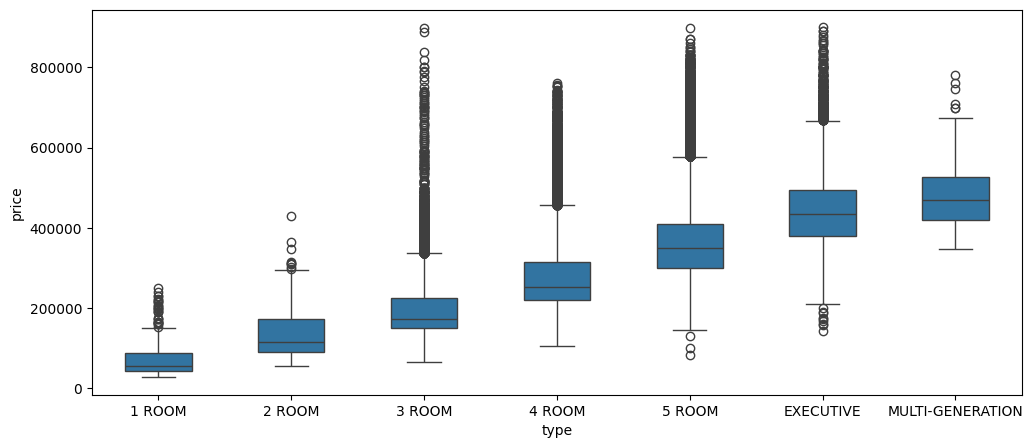

In [10]:
draw_boxplot(df_train_train, 'type')

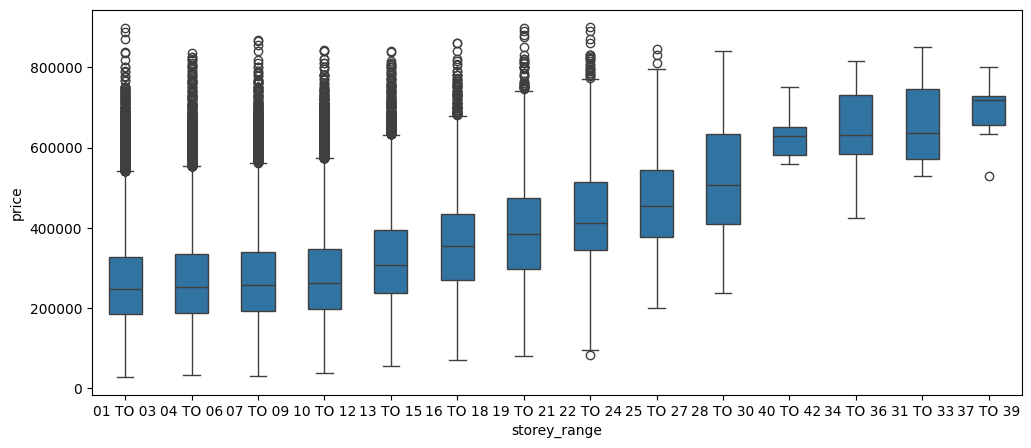

In [11]:
draw_boxplot(df_train_train, 'storey_range')

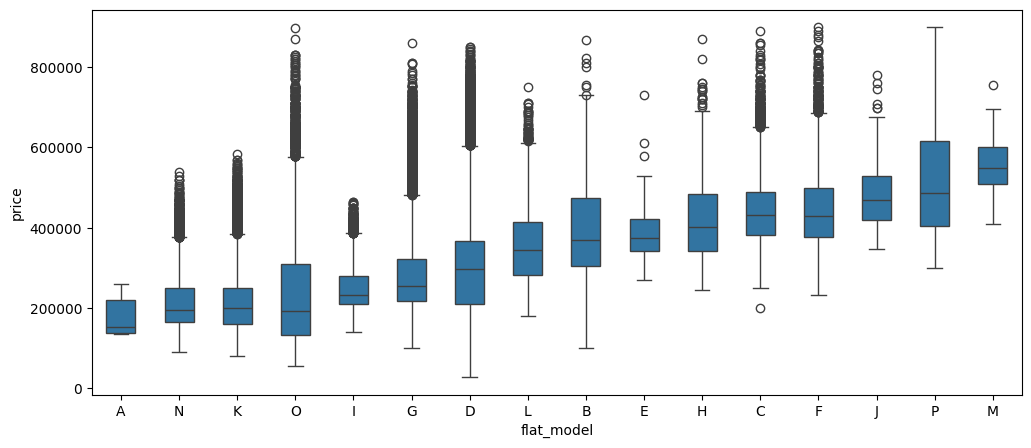

In [12]:
draw_boxplot(df_train_train, 'flat_model')

#### Распределение средней цены по признакам

In [13]:
def draw_mean_plot(data: pd.DataFrame, feature_name: str):
    """
    Построение scatterplot значения 'price' 
    по категориальному признаку,
    отсортированному по средним значения 'price'.

    Parameters
    ----------
    data : pd.DataFrame
        Датафрейм с данными для построения графика
    feature_name : str
        Название признака, по которому строится график

    Returns
    -------
    None        
    """
    show_data = data.groupby(feature_name)['price'].mean().sort_values()
    plt.figure(figsize=FIGURE_SIZE)
    sns.scatterplot(show_data, markers=False)
    if feature_name in ['date', 'location', 'block', 'street']:
        plt.xticks([])
    plt.show()


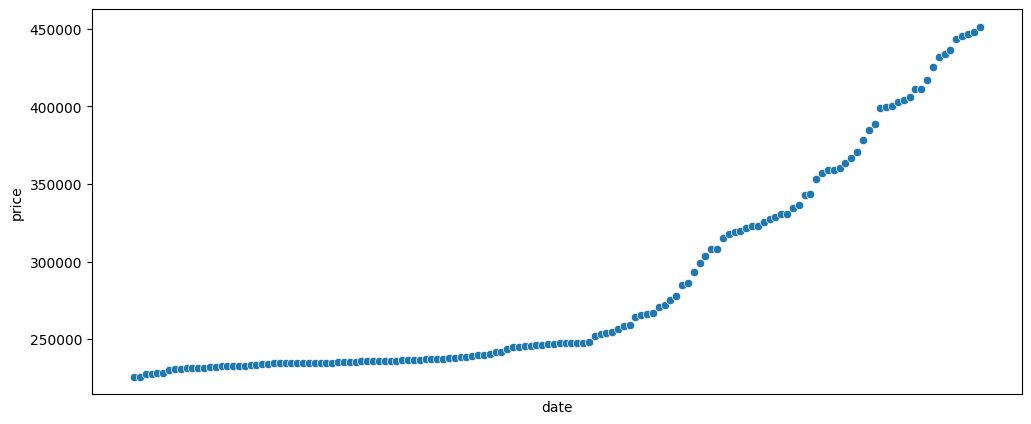

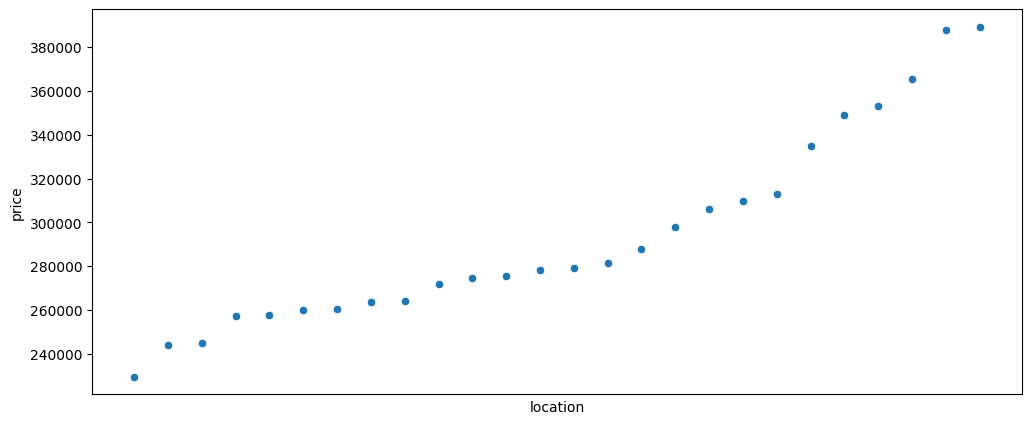

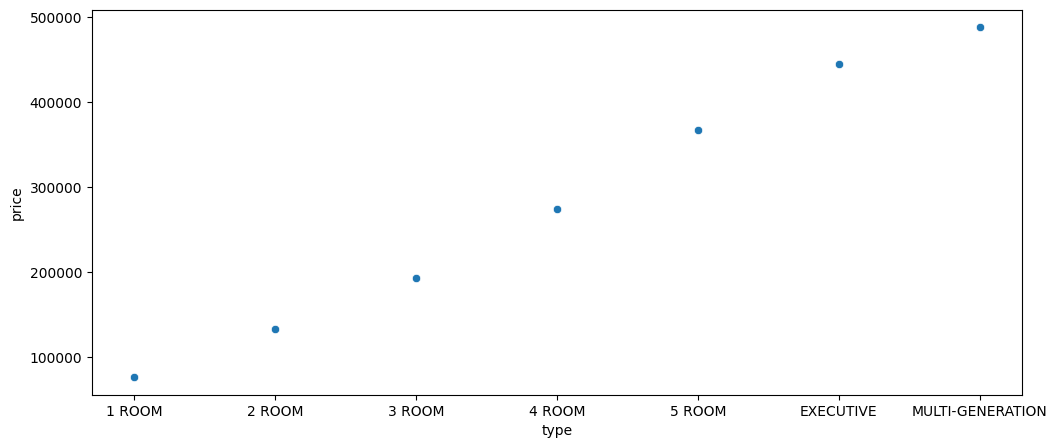

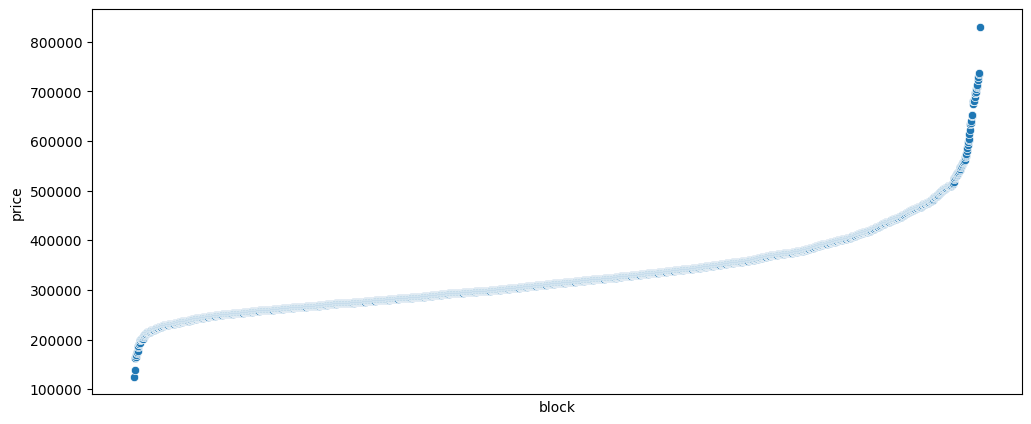

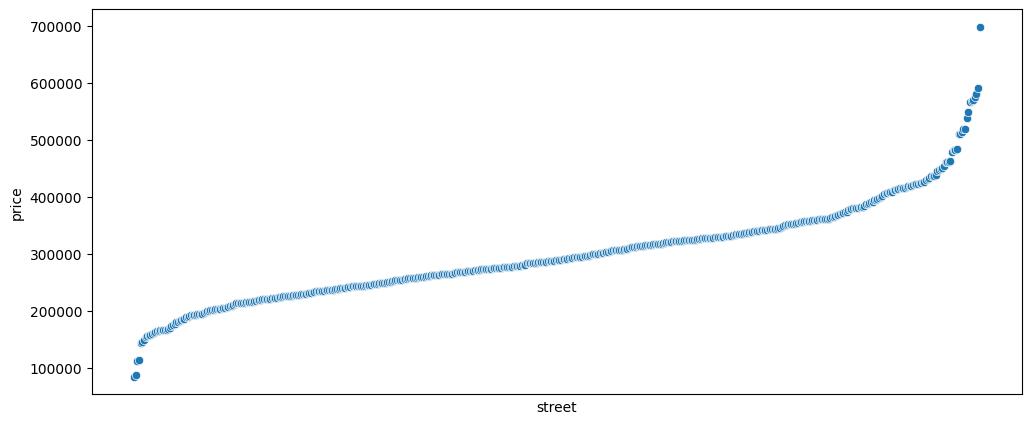

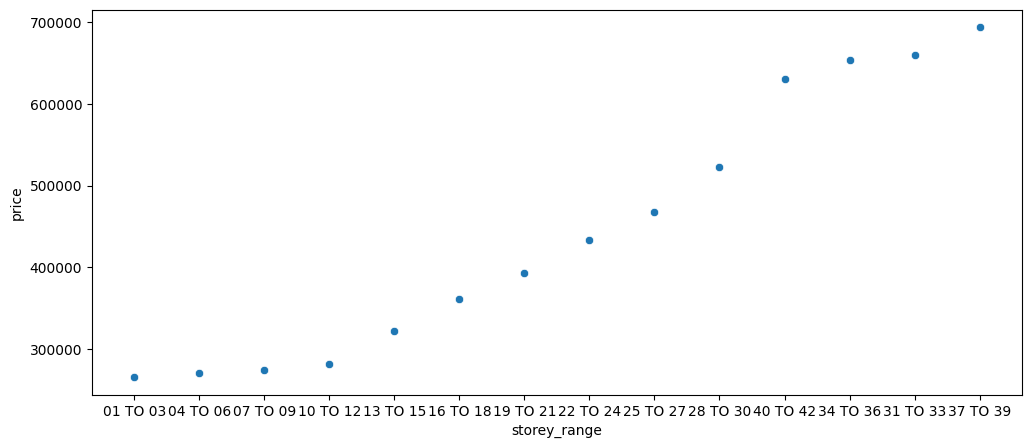

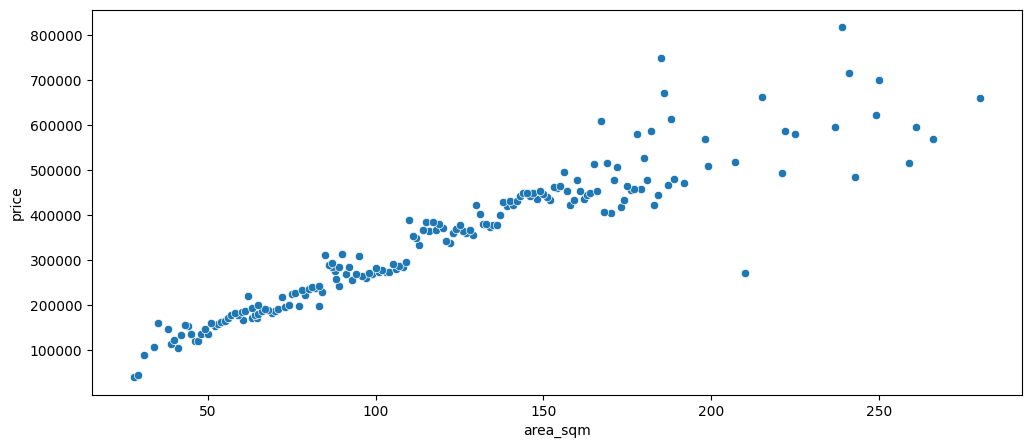

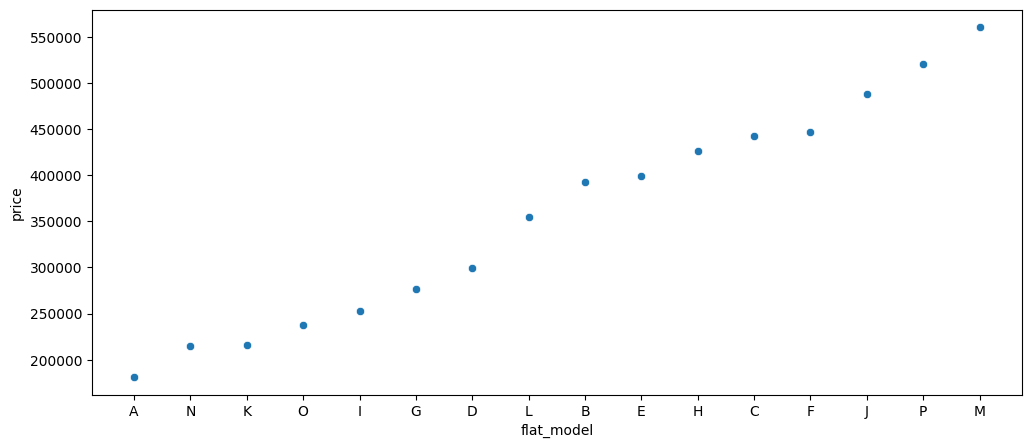

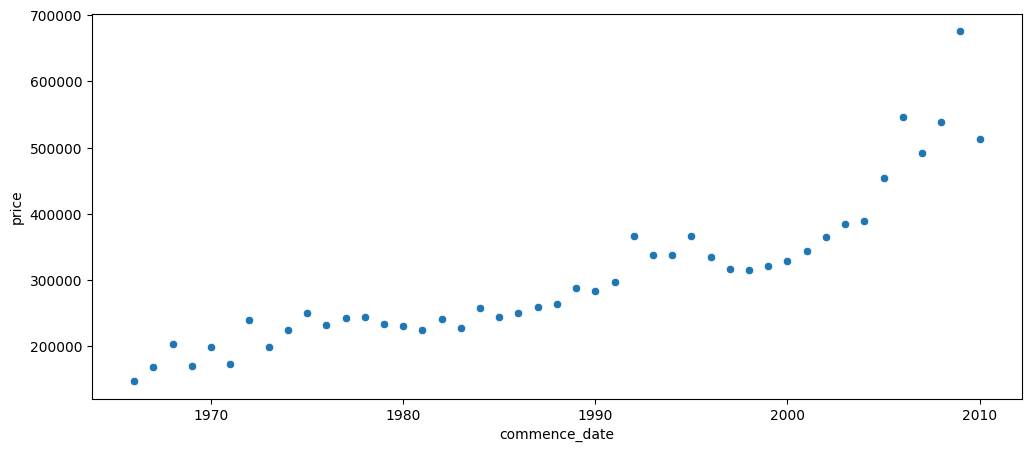

In [14]:
for col in df_train_train.columns:
    if col in ['house_id', 'price']:
        continue
    draw_mean_plot(df_train_train, col)


#### Зависимость цены и площади помещений

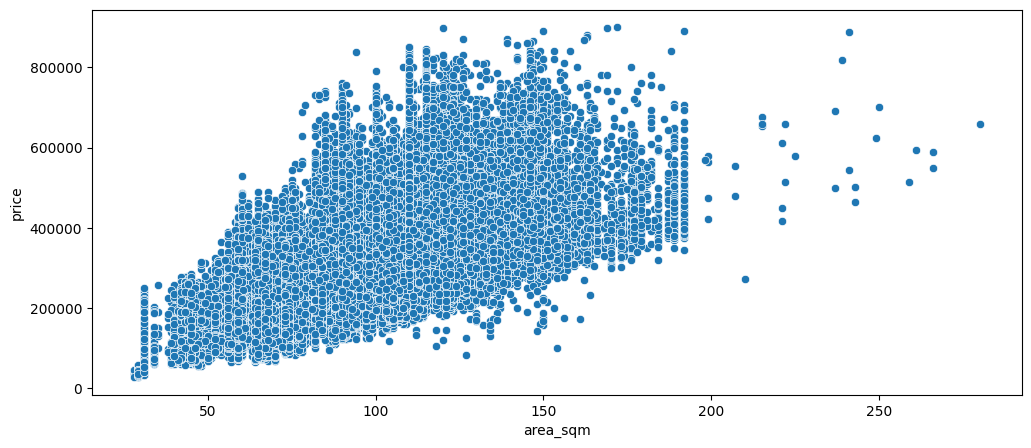

In [15]:
plt.figure(figsize=(12, 5))
sns.scatterplot(df_train_train, x='area_sqm', y='price')
plt.show()

Выводы:
- Все признаки являются информативными.  
- У всех признаков есть четкая взаимосвязь со средней ценой по признаку.
- В признаках `type`,  `area_sqm` и `flat_model` прослеживается линейная зависимость средней цены от признака.
- На некоторых графиках видны ярко выраженные выбросы.
   
Т.к. у всех категориальных признаков прослеживается четкая связь со средней ценой, то их можно закодировать при помощи Target Encoding.  

### Выделение новых признаков

Из признака `date` можно выделить отдельно год и отдельно месяц.  
Надо выяснить, будут ли эти новые признаки информативными.   

In [16]:
df_dates = df_train_train[['date', 'price']].copy()
df_dates['year'] = df_dates.date.str[:4]
df_dates['month'] = df_dates.date.str[5:7]

Если год и месяц представить как категориальные признаки, то распределение цен будет выглядеть так:

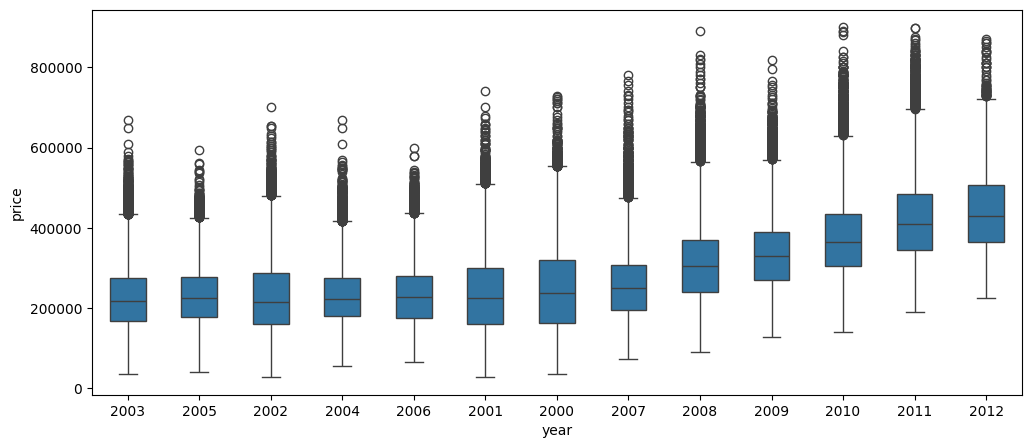

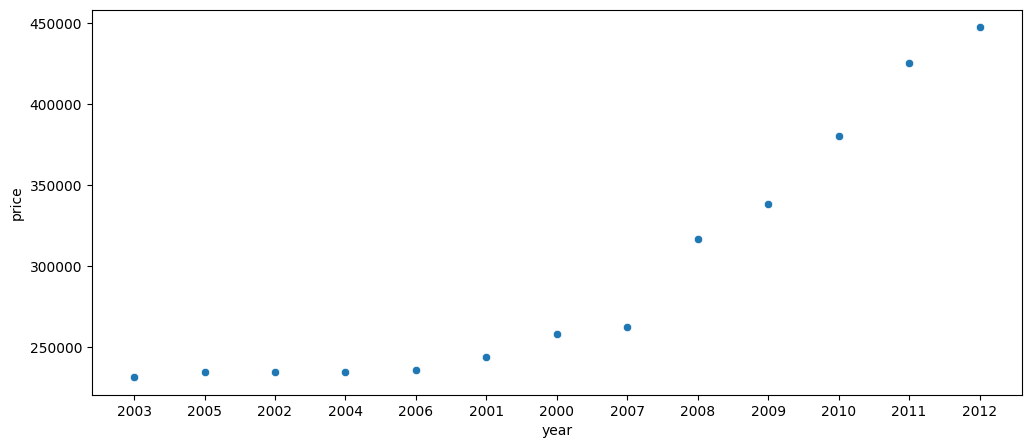

In [17]:
draw_boxplot(df_dates, 'year')
draw_mean_plot(df_dates, 'year')

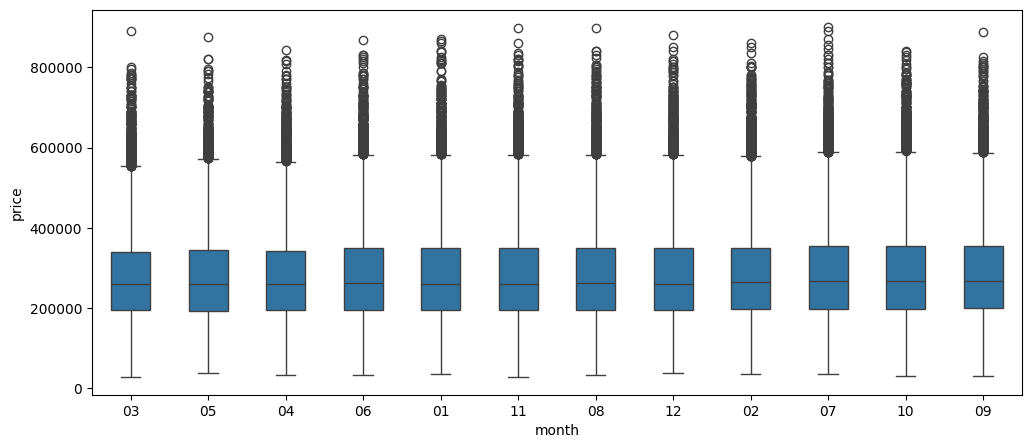

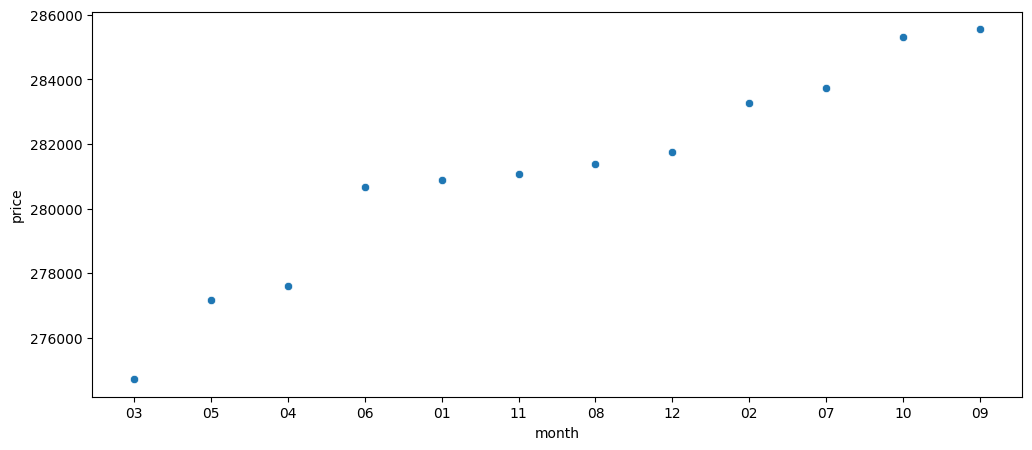

In [18]:
draw_boxplot(df_dates, 'month')
draw_mean_plot(df_dates, 'month')

Распределение средних цен по возрастанию года и месяца выглядит так:

In [19]:
df_dates = df_train_train[['date', 'price']].copy()
df_dates['year'] = df_dates.date.str[:4].astype(int)
df_dates['month'] = df_dates.date.str[5:7].astype(int)

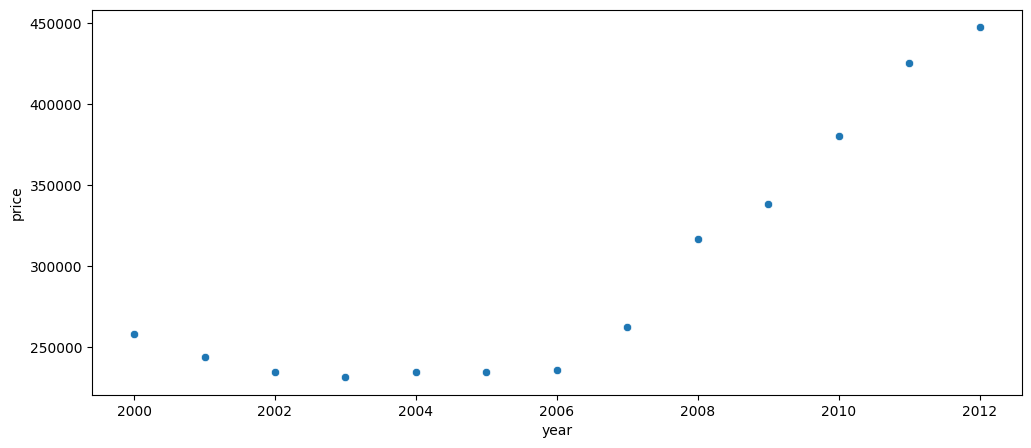

In [20]:
draw_mean_plot(df_dates, 'year')

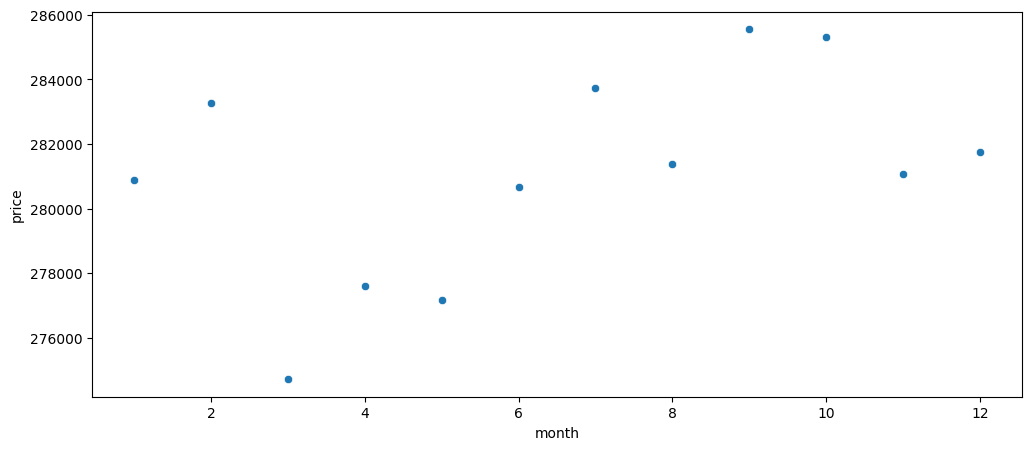

In [21]:
draw_mean_plot(df_dates, 'month')

In [22]:
del df_dates

Видно, что месяц является не информативным признаком и его не надо использовать, в то время как год является информативным.  
Признак `year` надо добавить в данные.  

### Целевая переменная - цена

Есть одно интересное наблюдение. На более чем 240 тысяч записей в тестовой выборке уникальных значений цены всего 4599.

In [23]:
print(f'Количество строк в данных:          {df_train_train.shape[0]}')
print(f'Количество уникальных значений цен: {df_train_train.price.nunique()}')

Количество строк в данных:          244548
Количество уникальных значений цен: 4599


In [24]:
df_train_train.price.sample(5)

105203    153000.0
193695    430000.0
93033     380000.0
52449     185000.0
195615    160000.0
Name: price, dtype: float64

Предположительно, все цены фактически являются целыми и возможно делятся нацело на 10, 100 или 1000.  
Это надо проверить.  

In [25]:
for i in [1, 10, 100, 1000, 10000]:
    tail_size = df_train_train[df_train_train.price % i != 0].shape[0]
    print(f"Делитель: {i: 6d}, Количество с остатком: {tail_size: 7d}, Доля от всех данных: {tail_size / df_train_train.shape[0]:0.3f}")

Делитель:      1, Количество с остатком:      48, Доля от всех данных: 0.000
Делитель:     10, Количество с остатком:    3041, Доля от всех данных: 0.012
Делитель:    100, Количество с остатком:    3487, Доля от всех данных: 0.014
Делитель:   1000, Количество с остатком:   19429, Доля от всех данных: 0.079
Делитель:  10000, Количество с остатком:  185089, Доля от всех данных: 0.757


Видно, что основная часть цен делится на 1000 без остатка. Это можно будет использовать при финальной обработки спрогнозированных цен, округлив их до 2 или 3 знака перед запятой. Возможно, это улучшит качество прогноза.  

### Выбросы

Наиболее яркий выброс, который виден на графиках это выброс в с `area_sqm` больше 200 и `price` мельше 300000.

In [26]:
df_train_train.query('area_sqm > 200 & price < 300000')

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price
179950,62827,2001-11,Mesa,5 ROOM,14,E Dolphin Ave,07 TO 09,210.0,B,1984,271888.0


## Подготовка данных

In [27]:
def transform_data(input_data: pd.DataFrame, encoder: TargetEncoder):
    '''
    Кодирует признаки и подготавливает данные 
    для обучения модели и получения прогнозов модели.

    Parameters
    ----------
    input_data : pd.DataFrame
        Датафрейм с исходными данными.
    encoder : TargetEncoder
        Кодировщик категориальных признаков.
        Если None,то создается и обучается на 
        переданных данных по списку 
        категориальных признаков.
        В ином случае - применяется к 
        категориальным признакам.

    Returns
    -------
    pd.DataFrame
        Датафрейм с обработанными данными.
    '''
    result = input_data.copy()
    build_encoder = encoder is None

    if encoder is None:
        encoder = TargetEncoder()
    
    result.set_index('house_id', inplace=True)
    result['year'] = result.date.str[:4].astype(int)

    categorial_features_list = ['date', 'location', 'type', 'block', 'street', 'storey_range', 'flat_model']
    if build_encoder:
        encoder.fit(result[categorial_features_list], result.price)
    result[categorial_features_list] = encoder.transform(result[categorial_features_list])

    return result, encoder


Разбиение данных на тренировочную и валидационную выборки и удаление выбросов.

In [28]:
# Разбиение данных на тренировочные и валидационные
X_train, X_valid = train_test_split(df_train_train, test_size=0.2, random_state=RND_STATE)

# Удаление выбровов из тренировочной выборки
X_train.drop(X_train.query('area_sqm > 200 & price < 300000').index, axis=0, inplace=True)

# Трансформация данных и выделение целевого признака
X_train, features_transformer = transform_data(X_train, None)
X_valid, _ = transform_data(X_valid, features_transformer)

y_train = X_train.price
X_train.drop('price', axis=1, inplace=True)

y_valid = X_valid.price
X_valid.drop('price', axis=1, inplace=True)


## Обучение модели

В качестве модели я решил использовать CatBoostRegressor.  
Для начала надо посмотреть, какой результат даст модель, обученная с гиперпараметрами по умолчанию.  

In [29]:
model = CatBoostRegressor(random_state=RND_STATE, verbose=0)

model.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, model.predict(X_train))
valid_mae = mean_absolute_error(y_valid, model.predict(X_valid))

print(f"Train MAE: {train_mae}")
print(f"Valid MAE: {valid_mae}")
print(f"MAE Diff : {valid_mae - train_mae}")

Train MAE: 13201.774998083953
Valid MAE: 13396.366871249778
MAE Diff : 194.59187316582575


Надо постараться улучшить этот результат путем подбора гиперпараметров.  
Основные гиперпараметры для подбора: `learning_rate`, `iterations` и `depth`.  
Изначально поиск параметров выполнялся методом `grid_search()`. 
```
params_grid = {
    'learning_rate': [1, 0.5],
    'iterations': [1000, 2000, 5000],
    'depth': [4, 5, 6],
}

model = CatBoostRegressor(random_state=RND_STATE, verbose=0)
grid_search_result = model.grid_search(params_grid, X=X_train, y=y_train, verbose=False)
print(grid_search_result['params'])
```
Однако из за ресурсоемкости процессв пришлось перейти к упрощенному способу подбора гиперпараметров.  

```
def get_current_mae(lr, itr, dep):
    result = cache.get((lr, itr, dep))
    if result:
        return result
    model = CatBoostRegressor(random_state=RND_STATE, 
                              verbose=0, 
                              learning_rate = lr, 
                              iterations = itr, 
                              depth = dep)

    model.fit(X_train, y_train)
    result = mean_absolute_error(y_valid, model.predict(X_valid))
    cache[(lr, itr, dep)] = result
    return result

curr_learning_rate = 0.2
curr_iterations = 25000
curr_depth = 5
init_call_order = [3,2,1]
cache = {}
alpha = 0.2

curr_mae = get_current_mae(curr_learning_rate, curr_iterations, curr_depth)
best_mae = curr_mae
curr_call_order = init_call_order.copy()

while len(curr_call_order) > 0:
    def print_new_params():
        print(f"learning_rate = {curr_learning_rate}, iterations = {curr_iterations}, depth = {curr_depth}, MAE = {best_mae}")
    
    def get_init_curr_call_order():
        res = init_call_order.copy()
        np.random.shuffle(res)
        return res
        
    curr_call = curr_call_order.pop()
    if curr_call == 1:
        # move iterations
        step = 10**int(np.log10(curr_iterations)) // int(1/alpha)
        new_iterations = curr_iterations + step
        new_mae = get_current_mae(curr_learning_rate, new_iterations, curr_depth)
        if new_mae < best_mae:
            best_mae = new_mae
            curr_iterations = new_iterations
            print_new_params()
            curr_call_order = get_init_curr_call_order()
            continue

        new_iterations = curr_iterations - step if curr_iterations - step > 1 else 1
        new_mae = get_current_mae(curr_learning_rate, new_iterations, curr_depth)
        if new_mae < best_mae:
            best_mae = new_mae
            curr_iterations = new_iterations
            print_new_params()
            curr_call_order = get_init_curr_call_order()
            continue

    elif curr_call == 2:
        # move curr_depth

        new_depth = curr_depth - 1 if curr_depth - 1 > 1 else 1
        new_mae = get_current_mae(curr_learning_rate, curr_iterations, new_depth)
        if new_mae < best_mae:
            best_mae = new_mae
            curr_depth = new_depth
            print_new_params()
            curr_call_order = get_init_curr_call_order()
            continue

        new_depth = curr_depth + 1
        new_mae = get_current_mae(curr_learning_rate, curr_iterations, new_depth)
        if new_mae < best_mae:
            best_mae = new_mae
            curr_depth = new_depth
            print_new_params()
            curr_call_order = get_init_curr_call_order()
            continue

    else:
        # move learning_rate
        step = alpha * 10**int(np.log10(curr_learning_rate * 1000)) / 1000

        new_learning_rate= curr_learning_rate - step if curr_learning_rate - step > 0 else 0.00001
        new_mae = get_current_mae(new_learning_rate, curr_iterations, curr_depth)
        if new_mae < best_mae:
            best_mae = new_mae
            curr_learning_rate = new_learning_rate
            print_new_params()
            curr_call_order = get_init_curr_call_order()
            continue
            
        new_learning_rate= curr_learning_rate + step if curr_learning_rate + step <= 1 else 1
        new_mae = get_current_mae(new_learning_rate, curr_iterations, curr_depth)
        if new_mae < best_mae:
            best_mae = new_mae
            curr_learning_rate = new_learning_rate
            print_new_params()
            curr_call_order = get_init_curr_call_order()
            continue

print('Finish')
```

В итоге были найдены следующие гиперпараметры: `learning_rate = 0.19, iterations = 11000, depth = 6`  

In [30]:
model = CatBoostRegressor(random_state=RND_STATE, verbose=0, learning_rate = 0.19, iterations = 11000, depth = 6)

model.fit(X_train, y_train)

train_mae = mean_absolute_error(y_train, model.predict(X_train))
valid_mae = mean_absolute_error(y_valid, model.predict(X_valid))

print(f"Train MAE: {train_mae}")
print(f"Valid MAE: {valid_mae}")
print(f"MAE Diff : {valid_mae - train_mae}")

Train MAE: 8908.612296730676
Valid MAE: 11234.260008295298
MAE Diff : 2325.647711564621


Теперь можно проверить гипотезу о том, что округление результата предсказания улучшит итоговый результат. 

In [31]:
for d in range(4):
    train_mae = mean_absolute_error(y_train, np.round(model.predict(X_train), -d))
    valid_mae = mean_absolute_error(y_valid, np.round(model.predict(X_valid), -d))

    print(f"\nDecimals: {d}")
    print(f"Train MAE: {train_mae}")
    print(f"Valid MAE: {valid_mae}")
    print(f"MAE Diff : {valid_mae - train_mae}")


Decimals: 0
Train MAE: 8908.61211503959
Valid MAE: 11234.26078572889
MAE Diff : 2325.6486706892993

Decimals: 1
Train MAE: 8908.621888242
Valid MAE: 11234.256717031281
MAE Diff : 2325.6348287892815

Decimals: 2
Train MAE: 8908.595103942507
Valid MAE: 11234.221100592926
MAE Diff : 2325.6259966504185

Decimals: 3
Train MAE: 8906.272390958768
Valid MAE: 11235.071887753014
MAE Diff : 2328.799496794247


В итоге можно видеть, что округление предсказания практически никак не улучшает итоговый результат.  
Особого смысла в округлении нет.  

## Финальная проверка результата

Обучение найденной модели на всей тренировочной выборке.   

In [32]:
# Копирование всей тренировочной выборки
X_train_all = df_train_train.copy()

# Удаление выбросов из тренировочной выборки
X_train_all.drop(X_train_all.query('area_sqm > 200 & price < 300000').index, axis=0, inplace=True)

# Трансформация данных и выделение целевого признака
X_train_all, features_transformer = transform_data(X_train_all, None)

# Разделение данных на признаки и целевую переменную
y_train_all = X_train_all.price
X_train_all.drop('price', axis=1, inplace=True)

# Финальное обучение модели
model = CatBoostRegressor(random_state=RND_STATE,
                          verbose=0,
                          learning_rate = 0.19,
                          iterations = 11000,
                          depth = 6)

model.fit(X_train_all, y_train_all)

train_all_mae = mean_absolute_error(y_train_all, model.predict(X_train_all))

print(f"Train MAE (final): {train_all_mae}")

Train MAE (final): 9144.617811533864


Финальная проверка модели на отложенной тестовой выборке.  

In [33]:
X_final, _ = transform_data(df_train_test, features_transformer)
y_final = X_final.price
X_final.drop('price', axis=1, inplace=True)

final_mae = mean_absolute_error(y_final, model.predict(X_final))

print(f"Test MAE (final): {final_mae}")

Test MAE (final): 11208.17642606707


## Получение прогнозов для соревнования и сохранение их в файл

In [34]:
X_result, _ = transform_data(df_test, features_transformer)

result = X_result[[]].copy()

result['price'] = model.predict(X_result)

result.to_csv('./simple_house_price.csv')

Итоговое значение метрики на соревновании: 11219.20894   
По состоянию на 07.10.2024 это второй результат среди всех учасников.  